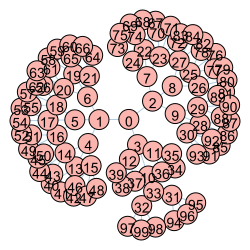

In [1]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
G = Graph.Tree(100, 3)


G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})
#plotting
p_style = {"bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
plot(G, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

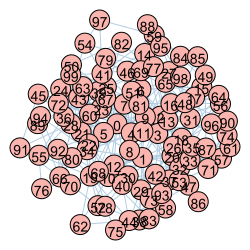

In [2]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
G = Graph.Barabasi(n = 100, m = 3, directed = False)


G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})
#plotting
p_style = {"bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
plot(G, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [2]:
# Parameters
# Transmission rate
beta = 0.5
# Recovery rate
gamma = 0.1
#Time 
T = 30
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([0]), 'prob'] = 0.01

In [3]:
def SIR_DMP(g, p0, beta, gamma, T):
    
    # Get initial infection probabilities for each node
    start, nodes, init_probs = time.time(), p0['node'].tolist(), p0['prob'].tolist()    
    
    # initialising marginals and messages
    mrg_s = np.zeros((T, len(nodes)))
    mrg_i = np.zeros((T, len(nodes)))
    mrg_r = np.zeros((T, len(nodes)))
    msg_phi = {}
    msg_theta = {}
    
    # Initialize message dictionaries for each edge
    for edge in g.itertuples(index=False):
        edge = tuple(sorted((edge.source, edge.target)))
        msg_phi[edge] = np.zeros(T)
        msg_phi[tuple(reversed(edge))] = np.zeros(T)

        msg_theta[edge] = np.ones(T)
        msg_theta[tuple(reversed(edge))] = np.ones(T)
    
    # Set initial Susceptible probabilities
    mrg_i[0, :] = np.array(init_probs)
    mrg_s[0, :] = 1.0 - np.array(init_probs)
    for k, v in msg_phi.items():
        v[0] = init_probs[k[0]]
        
        
    # Precompute neighbors
    neighbors = {i: set() for i in nodes}
    for edge in g.itertuples(index=False):
        source, target = edge.source, edge.target
        neighbors[source].add(target)
        neighbors[target].add(source) 


    
    # DMP
    for t in range(1,T):
        # Update theta values
        for e, v in msg_theta.items():
            v[t] = v[t-1] - beta * msg_phi[e][t-1]
        
        # Update susceptible
        for i in range(len(nodes)):
            # Start with previous time step's susceptible probability
            mrg_s[t, i] = 1.0 - init_probs[i]
            # Update based on neighbors
            for neighbor in neighbors[i]:
                mrg_s[t, i] *= msg_theta[(neighbor, i)][t]
                
        # Update phi     
        for e, w in msg_phi.items():
            w[t] = (1.0 - beta) * (1.0 - gamma) * w[t-1]
            w[t] += mrg_s[t-1, e[0]] / msg_theta[e[::-1]][t-1]
            w[t] -= mrg_s[t, e[0]] / msg_theta[e[::-1]][t]
            w[t] = max(0, min(w[t], 1))
        
        # Update recovered
        for i in range(len(nodes)):
            mrg_r[t, i] = mrg_r[t-1, i] + gamma * (1.0 - mrg_s[t-1, i] - mrg_r[t-1, i])
        
        # Update infected
        for i in range(len(nodes)):
            mrg_i[t, i] = 1.0 - mrg_s[t, i] - mrg_r[t, i]
            
    #print("DMP Runtime:   " + str(round(time.time() - start, 2)) + " seconds")
    return mrg_s, mrg_i, mrg_r, msg_phi, msg_theta

In [4]:
predicted_s, predicted_i, predicted_r , p, t = SIR_DMP(g, p0, beta, gamma, T)

In [5]:
predicted_s

array([[0.99      , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99      , 0.995     , 0.995     , ..., 1.        , 1.        ,
        1.        ],
       [0.99      , 0.99275   , 0.99275   , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.99      , 0.99090909, 0.99090909, ..., 0.99316988, 0.99316988,
        0.99316988],
       [0.99      , 0.99090909, 0.99090909, ..., 0.99316987, 0.99316987,
        0.99316987],
       [0.99      , 0.99090909, 0.99090909, ..., 0.99316987, 0.99316987,
        0.99316987]])

In [6]:
predicted_i

array([[0.01      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.009     , 0.005     , 0.005     , ..., 0.        , 0.        ,
        0.        ],
       [0.0081    , 0.00675   , 0.00675   , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0005815 , 0.00064611, 0.00064611, ..., 0.00088627, 0.00088627,
        0.00088627],
       [0.00052335, 0.0005815 , 0.0005815 , ..., 0.00079765, 0.00079765,
        0.00079765],
       [0.00047101, 0.00052335, 0.00052335, ..., 0.00071789, 0.00071789,
        0.00071789]])

In [7]:
predicted_r

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.001     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0019    , 0.0005    , 0.0005    , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0094185 , 0.0084448 , 0.0084448 , ..., 0.00594385, 0.00594385,
        0.00594385],
       [0.00947665, 0.00850941, 0.00850941, ..., 0.00603247, 0.00603247,
        0.00603247],
       [0.00952899, 0.00856756, 0.00856756, ..., 0.00611224, 0.00611224,
        0.00611224]])